In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv('BRITANNIA.csv')

In [34]:
df.shape[0]

5305

In [35]:
df.shape[1]

14

In [9]:
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,BRITANNIA,EQ,703.25,705.0,759.50,705.0,758.0,756.90,741.01,7512,5.566488e+11,NaN,NaN,NaN
1,2000-01-04,BRITANNIA,EQ,756.90,710.0,770.00,710.0,740.0,754.55,742.52,8135,6.040391e+11,NaN,NaN,NaN
2,2000-01-05,BRITANNIA,EQ,754.55,755.0,759.00,705.0,740.0,735.30,739.92,6095,4.509784e+11,NaN,NaN,NaN
3,2000-01-06,BRITANNIA,EQ,735.30,740.0,794.15,740.0,770.0,785.65,788.83,19697,1.553756e+12,NaN,NaN,NaN
4,2000-01-07,BRITANNIA,EQ,785.65,808.0,848.50,798.0,848.5,848.50,827.53,33107,2.739708e+12,NaN,NaN,NaN


In [10]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df['Close'] = scaler.fit_transform(df[['Close']])

In [12]:
data = df['Close'].values.reshape(-1, 1)
training_size = int(len(data)*0.65)
test_size = len(data) - training_size
train_data,test_data=data[0:training_size,:],data[training_size:len(data),:1]


In [13]:
training_size,test_size

(3448, 1857)

In [14]:
train_data

array([[0.06407112],
       [0.06371309],
       [0.06078034],
       ...,
       [0.08094397],
       [0.08215515],
       [0.08843962]])

In [15]:
def create_dataset(dataset,time_step=1):
  dataX,dataY = [],[]
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i+time_step,0])
  return np.array(dataX),np.array(dataY)

In [16]:
time_step = 100
x_train,y_train = create_dataset(train_data,time_step)
x_test,y_test = create_dataset(test_data,time_step)

In [17]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [18]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [19]:
model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test), verbose=1)

Epoch 1/10
53/53 [==============================] - 7s 27ms/step - loss: 9.7898e-04 - val_loss: 0.0011
Epoch 2/10
53/53 [==============================] - 1s 12ms/step - loss: 1.5174e-04 - val_loss: 9.9981e-04
Epoch 3/10
53/53 [==============================] - 1s 12ms/step - loss: 1.2694e-04 - val_loss: 8.7974e-04
Epoch 4/10
53/53 [==============================] - 1s 12ms/step - loss: 1.1412e-04 - val_loss: 9.8571e-04
Epoch 5/10
53/53 [==============================] - 1s 12ms/step - loss: 1.0375e-04 - val_loss: 0.0026
Epoch 6/10
53/53 [==============================] - 1s 13ms/step - loss: 9.9926e-05 - val_loss: 0.0023
Epoch 7/10
53/53 [==============================] - 1s 13ms/step - loss: 9.2368e-05 - val_loss: 0.0025
Epoch 8/10
53/53 [==============================] - 1s 12ms/step - loss: 8.8898e-05 - val_loss: 0.0026
Epoch 9/10
53/53 [==============================] - 1s 13ms/step - loss: 8.3536e-05 - val_loss: 0.0046
Epoch 10/10
53/53 [==============================] - 1s 13ms/

In [20]:
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

55/55 [==============================] - 0s 5ms/step


In [21]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [22]:
train_mae_loss = np.mean(np.abs(train_predict - scaler.inverse_transform(y_train.reshape(-1, 1))), axis=1)
test_mae_loss = np.mean(np.abs(test_predict - scaler.inverse_transform(y_test.reshape(-1, 1))), axis=1)

In [23]:
test_score_df = pd.DataFrame(index=df.index[training_size + time_step + 1:])
test_score_df['loss_mae'] = test_mae_loss
test_score_df['threshold'] = 0.65
test_score_df['anomaly'] = test_score_df['loss_mae'] > test_score_df['threshold']

print(test_score_df.head())

             loss_mae  threshold  anomaly
Date                                     
2014-03-20  25.899768       0.65     True
2014-03-21  21.324390       0.65     True
2014-03-22  16.166980       0.65     True
2014-03-24   9.710852       0.65     True
2014-03-25  25.899329       0.65     True


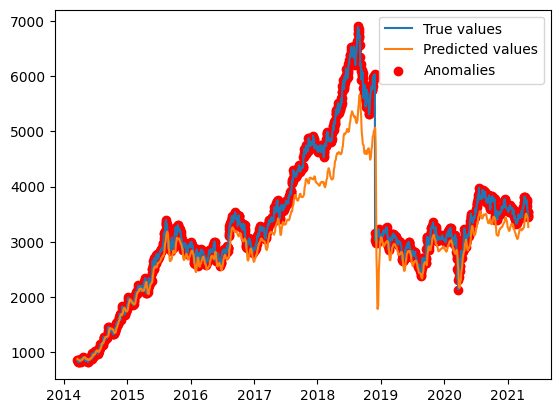

In [24]:
plt.plot(df.index[training_size + time_step + 1:], scaler.inverse_transform(data[training_size + time_step + 1:]), label='True values')
plt.plot(df.index[training_size + time_step + 1:], test_predict, label='Predicted values')
plt.scatter(test_score_df[test_score_df['anomaly']].index,
            scaler.inverse_transform(data[training_size + time_step + 1:])[test_score_df['anomaly']],
            color='red', label='Anomalies')
plt.legend()
plt.show()